In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

sys.path.append("../..")

from cyclops.feature_handler import FeatureHandler
from drift_detector.explainer import ShiftExplainer
from drift_detector.experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.utils import *
from baseline_models.static.utils import run_model

2022-07-14 08:53:10,770 INFO cyclops.orm     - Database setup, ready to run queries!


# Config Parameters #

In [10]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]
RANDOM_RUNS = 25
SIGN_LEVEL = 0.05
CALC_ACC = True
TIMESTEPS = 6
AGGREGATION_TYPE = "time"
SCALE=True
CONTEXT_TYPE="lstm"
REPRESENTATION="rf"
DR_TECHNIQUES = ["BBSDs_trained_LSTM"]#["NoRed","SRP", "PCA", "kPCA", "Isomap","BBSDs_untrained_FFNN","BBSDs_untrained_LSTM", "BBSDs_trained_LSTM"]
MD_TESTS = ["Univariate"]#["LSDD", "MMD", "LK","Classifier","Context-Aware MMD"]

# Query Data

In [3]:
admin_data, x, y = get_gemini_data(PATH)

2022-07-14 08:53:10,874 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-14 08:53:11,224 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-14 08:53:11,342 INFO cyclops.feature_handler - Loading features from file...
2022-07-14 08:53:11,344 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-14 08:53:11,345 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-14 08:53:11,374 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-14 08:53:16,254 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-14 08:53:24,606 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


# Input Parameters #

In [4]:
SHIFT = input("Select experiment: ")  # covid,seasonal,hosp_type
OUTCOME = input("Select outcome variable: ") # mortality

if SHIFT == "covid":
    EXPERIMENTS = ["pre-covid", "covid"]
    HOSPITAL= ["SMH","MSH","UHNTG","UHNTW","PMH","THPC","THPM"]
    MODEL_PATH="../../saved_models/covid_lstm.pt"

if SHIFT == "seasonal_summer":
    EXPERIMENTS = ["seasonal_summer_baseline","seasonal_summer"] 
    MODEL_PATH="../../saved_models/seasonal_summer_lstm.pt"

if SHIFT == "seasonal_winter":
    EXPERIMENTS = ["seasonal_winter_baseline","seasonal_winter"] 
    MODEL_PATH="../../saved_models/seasonal_winter_lstm.pt"
    
if SHIFT == "hosp_type_academic":
    EXPERIMENTS = ["hosp_type_academic_baseline","hosp_type_academic"]
    HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]
    MODEL_PATH="../../saved_models/hosp_type_academic_lstm.pt"

if SHIFT == "hosp_type_community":
    EXPERIMENTS = ["hosp_type_community_baseline","hosp_type_community"]
    HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]
    MODEL_PATH="../../saved_models/hosp_type_community_lstm.pt"

MODEL_PATH = os.path.join(os.getcwd(),MODEL_PATH)
HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]

Select experiment:  hosp_type_community
Select outcome variable:  mortality


# Drift Tests #

In [5]:
#Run test
run = str(2)
PATH = PATH + run

In [ ]:
# Run shift experiments
if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "rb") as f:
        mean_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "rb") as f:
        mean_dr_md_dist = pickle.load(f)
else:
    mean_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    mean_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "rb") as f:
        std_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "rb") as f:
        std_dr_md_dist = pickle.load(f)
        
else:
    std_dr_md_pval = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)
    std_dr_md_dist = np.ones(
        (len(EXPERIMENTS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)


for si, SHIFT in enumerate(EXPERIMENTS):
    for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
        for mi, MD_TEST in enumerate(MD_TESTS):
            if np.any(mean_dr_md_pval[si, di, mi, :] == -1):
                print(
                    "{} | {} | {} | {}".format(
                        SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                    )
                )
                if True:
                    mean_p_vals, std_p_vals, mean_dist, std_dist = run_shift_experiment(
                        shift=SHIFT,
                        admin_data=admin_data,
                        x=x, 
                        y=y,
                        outcome=OUTCOME,
                        hospital=HOSPITAL,
                        path=PATH,
                        aggregation_type=AGGREGATION_TYPE,
                        scale=SCALE,
                        dr_technique=DR_TECHNIQUE,
                        model_path=MODEL_PATH,
                        md_test=MD_TEST,
                        context_type=CONTEXT_TYPE,
                        representation=REPRESENTATION,
                        samples=SAMPLES,
                        dataset=DATASET,
                        sign_level=SIGN_LEVEL,
                        timesteps=TIMESTEPS,
                        random_runs=RANDOM_RUNS,
                        calc_acc=CALC_ACC
                    )
                    
                    mean_dr_md_pval[si, di, mi, :] = mean_p_vals
                    std_dr_md_pval[si, di, mi, :] = std_p_vals
                    mean_dr_md_dist[si, di, mi, :] = mean_dist
                    std_dr_md_dist[si, di, mi, :] = std_dist


Select Pre-Processing:  NoRed
Select Two-Sample Testing:  Context-Aware MMD
Plot:  P-Value


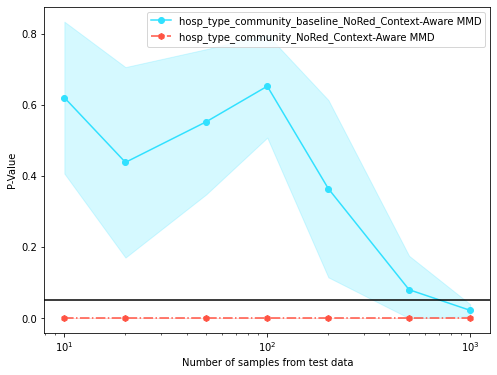

In [9]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")
PLOT_METRIC = input("Plot: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(EXPERIMENTS):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST and 
                    PLOT_METRIC == "Distance"
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_dist[si, di, mi, :],
                        std_dr_md_dist[si, di, mi, :],
                        fmt=linestyles[si] + markers[si],
                        color=colorscale(colors[si], brightness[si]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
            elif (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST and 
                    PLOT_METRIC == "P-Value"
            ):
                errorfill(
                        np.array(SAMPLES),
                        mean_dr_md_pval[si, di, mi, :],
                        std_dr_md_pval[si, di, mi, :],
                        fmt=linestyles[si] + markers[si],
                        color=colorscale(colors[si], brightness[si]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test data")
plt.ylabel(PLOT_METRIC)
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(mean_dr_md_dist, f)
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(std_dr_md_dist, f)

# Build Model #

In [ ]:
scale = True

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, orig_dims, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITAL, 1, shuffle=True)

aggregation_type = "time_flatten"
numerical_cols = get_numerical_cols(PATH)

# Normalize data
(X_tr_normalized, y_tr),(X_val_normalized, y_val), (X_t_normalized, y_t) = normalize_data(aggregation_type, admin_data, TIMESTEPS, X_tr, y_tr, X_val, y_val, X_t, y_t)

# Scale data
if scale:
    X_tr_normalized, X_val_normalized, X_t_normalized = scale_data(numerical_cols, X_tr_normalized, X_val_normalized, X_t_normalized)
# Process data
X_tr_final, X_val_final, X_t_final = process_data(aggregation_type, TIMESTEPS, X_tr_normalized, X_val_normalized, X_t_normalized)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITAL), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr_final, y_tr, X_val_final, y_val)

### Performance on Source Data ###

<AxesSubplot:title={'center':'Average Precision: 0.970686'}, xlabel='Recall', ylabel='Precision'>

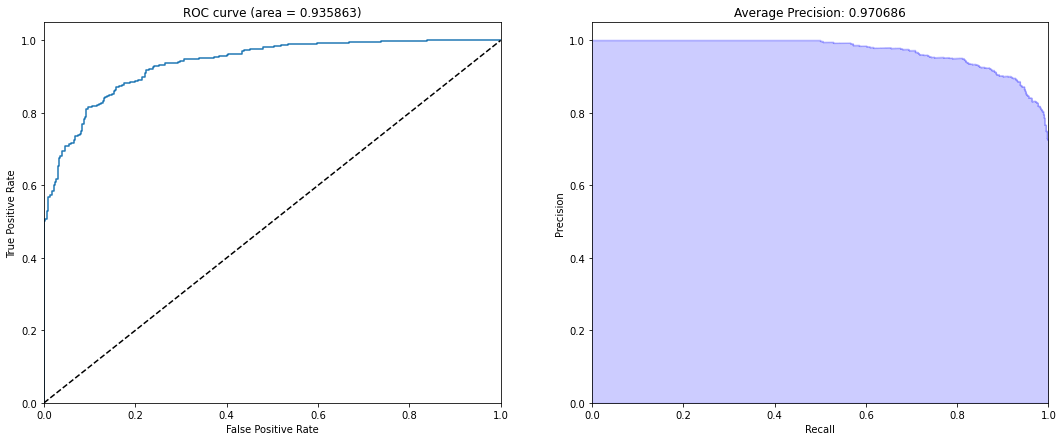

In [13]:
y_pred_prob = optimised_model.predict_proba(X_val_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'Average Precision: 0.573851'}, xlabel='Recall', ylabel='Precision'>

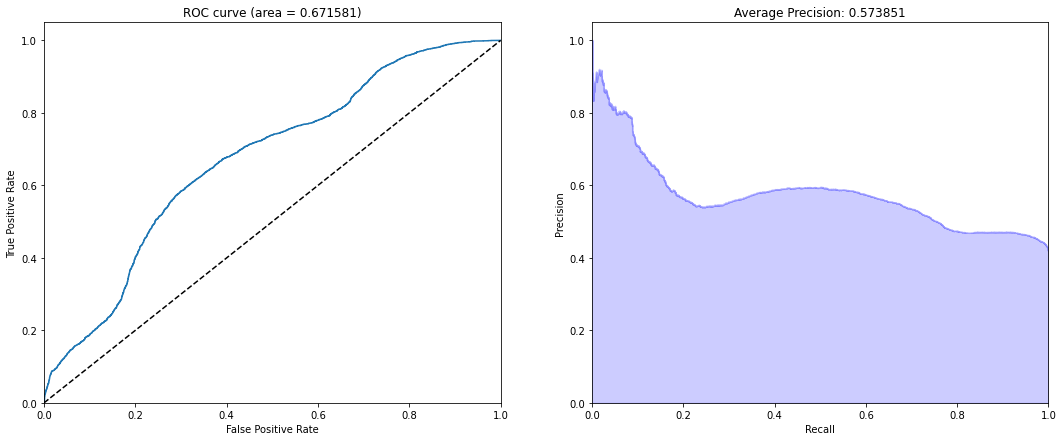

In [14]:
y_pred_prob = optimised_model.predict_proba(X_t_final)[:, 1]
fpr, tpr, thresholds = roc_curve(y_t, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_t, y_pred_prob)
avg_pr = average_precision_score(y_t, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

## Performance by Sample Size ##

In [25]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val, y_val = unison_shuffled_copies(X_val_final, y_val)
        X_test, y_test = unison_shuffled_copies(X_t_final, y_t)

        y_val_pred_prob = optimised_model.predict_proba(X_val_final[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val[:sample], y_val_pred_prob, pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val[:sample], y_val_pred_prob)

        y_test_pred_prob = optimised_model.predict_proba(X_t_final[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_t[:sample], y_test_pred_prob, pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_t[:sample], y_test_pred_prob)

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

No negative samples in y_true, false positive value should be meaningless
No negative samples in y_true, false positive value should be meaningless


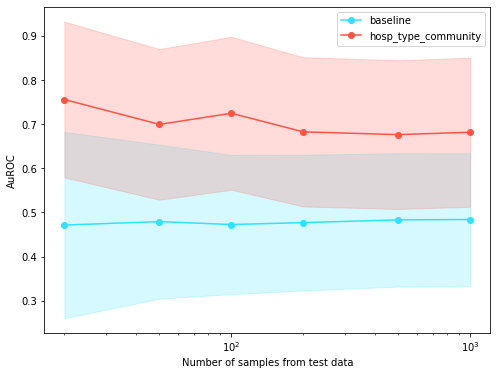

In [26]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

In [ ]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val, columns=feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_test, columns=feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if x != 0))
)
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()